# Networks Project


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random as rd
from collections import Counter
from scipy.optimize import curve_fit


Initial playing about with network representation and visualisation

In [2]:
#will dfine a list that wolds all the vertices
#a vertex is represented as the list which holds all its neighbours
#we can make an initian graph
g1 = []
e0 = [1,2] #will include the subcript 0 to be in concordance
#with python's list notation (which includes a zeroth entry in a list)
e1 = [0,1]
e2 = [0,2]
g1 = [e0,e1,e2]
print(g1)
#we can also save the nodes as a single number
n = 2
#this automatically means that we have nodes 0,1,2 (--> 3 nodes)
#we do not need a list to do this

#we also need a list to store the degree
d = [2,2,2]

[[1, 2], [0, 1], [0, 2]]


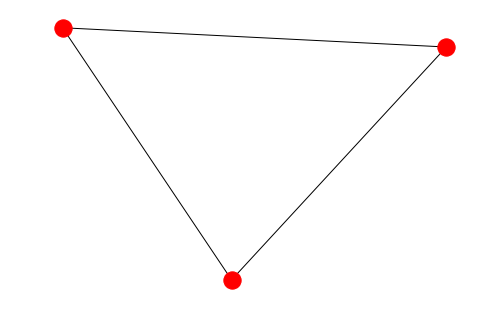

In [3]:
G=nx.Graph()
G.add_edges_from(g1)
nx.draw(G)
plt.show()

In [4]:
#I think I have decided how to grow my network
#it will be a list of edges
#then every time I need to visualise I can throw it in networks
#so..we can stat with g1 above and grow it using the BA algorythm

def step(edges,degree,t,m):
    """
    Take a tree with a set of edges and a degree distribution and grows it using the BA algorythm
    The set of edges is sufficiet to describe the tree but the degree distribution is kept for convinience
    (So that we don't have to count it from the edges every time)
    """
    t += 1
    #add a new vertex
    degree.append(m) #this new vertex will have m extra degrees

    #print(degree)
    for i in range(0,m): 
        #pick random edge
        e = rd.choice(edges)
        #pick random node from thsi edge
        node = rd.choice(e)
        degree[node] += 1
        newedge = [len(degree)-1,node] #len(degree) is also the number of the last vertex, node is counting the last node
        edges.append(newedge)   
    return edges,degree,t

In [5]:
#this is the same tree explained above just repeated here for convinience
g1 = []
e0 = [0,1] 
#e1 = [0,1]
#e2 = [0,2]
g1 = [e0]
d3 = [1,1,1]

[[0, 1], [3, 1], [3, 0]] [2, 2, 1, 2]


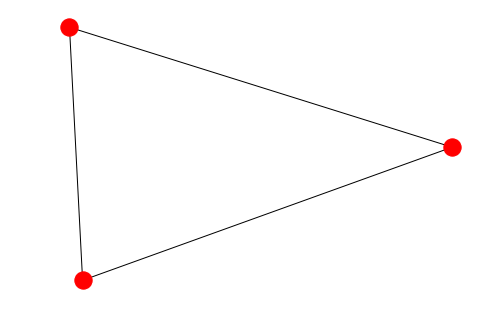

<Figure size 432x288 with 0 Axes>

In [6]:
t = 0
g1, d3, t1 = step(g1,d3,t,2)
print(g1,d3)
G=nx.Graph()
G.add_edges_from(g1)
nx.draw(G)

plt.show()
plt.savefig("Figures\\Network_Example.pdf")

In [7]:
#having aquired a degree distribution that seems right we can move on to log-binning the data and doing proper statistics
def logbin(data, scale = 1., zeros = False):
    """
    logbin(data, scale = 1., zeros = False)

    Log-bin frequency of unique integer values in data. Returns probabilities
    for each bin.

    Array, data, is a 1-d array containing full set of event sizes for a
    given process in no particular order. For instance, in the Oslo Model
    the array may contain the avalanche size recorded at each time step. For
    a complex network, the array may contain the degree of each node in the
    network. The logbin function finds the frequency of each unique value in
    the data array. The function then bins these frequencies in logarithmically
    increasing bin sizes controlled by the scale parameter.

    Minimum binsize is always 1. Bin edges are lowered to nearest integer. Bins
    are always unique, i.e. two different float bin edges corresponding to the
    same integer interval will not be included twice. Note, rounding to integer
    values results in noise at small event sizes.

    Parameters
    ----------

    data: array_like, 1 dimensional, non-negative integers
          Input array. (e.g. Raw avalanche size data in Oslo model.)

    scale: float, greater or equal to 1.
          Scale parameter controlling the growth of bin sizes.
          If scale = 1., function will return frequency of each unique integer
          value in data with no binning.

    zeros: boolean
          Set zeros = True if you want binning function to consider events of
          size 0.
          Note that output cannot be plotted on log-log scale if data contains
          zeros. If zeros = False, events of size 0 will be removed from data.

    Returns
    -------

    x: array_like, 1 dimensional
          Array of coordinates for bin centres calculated using geometric mean
          of bin edges. Bins with a count of 0 will not be returned.
    y: array_like, 1 dimensional
          Array of normalised frequency counts within each bin. Bins with a
          count of 0 will not be returned.
    """
    if scale < 1:
        raise ValueError('Function requires scale >= 1.')
    count = np.bincount(data)
    tot = np.sum(count)
    smax = np.max(data)
    if scale > 1:
        jmax = np.ceil(np.log(smax)/np.log(scale))
        if zeros:
            binedges = scale ** np.arange(jmax + 1)
            binedges[0] = 0
        else:
            binedges = scale ** np.arange(1,jmax + 1)
            # count = count[1:]
        binedges = np.unique(binedges.astype('uint64'))
        x = (binedges[:-1] * (binedges[1:]-1)) ** 0.5
        y = np.zeros_like(x)
        count = count.astype('float')
        for i in range(len(y)):
            y[i] = np.sum(count[binedges[i]:binedges[i+1]]/(binedges[i+1] - binedges[i]))
            # print(binedges[i],binedges[i+1])
        # print(smax,jmax,binedges,x)
        # print(x,y)
    else:
        x = np.nonzero(count)[0]
        y = count[count != 0].astype('float')
        if zeros != True and x[0] == 0:
            x = x[1:]
            y = y[1:]
    y /= tot
    x = x[y!=0]
    y = y[y!=0]
    return x,y

Article on scale-free networks and how to compare models to data:
https://www.nature.com/articles/s41467-019-08746-5#auth-2

In [8]:
#write a functio to automate:
def grow_a_net(T,m):
    g1 = []
    e0 = [0,1] 
    #e1 = [0,1]
    #e2 = [0,2]
    g1 = [e0,]
    d = [1,1]
    for t in range(T):
            g1, d, t1 = step(g1,d,t,m)
            
    return g1,d,t1

In [50]:
%time g1, d, t1 = grow_a_net(10000000,2)

Wall time: 54.9 s


In [52]:
len(d)

10000002

Acquisition of data for good statistics:

In [10]:
#let's grow some nets!
d50 =[]
for i in range(10):
    %time g1, d, t1 = grow_a_net(99998,50)
    d50.append(d)

Wall time: 34.9 s
Wall time: 34.7 s
Wall time: 31.7 s
Wall time: 39.8 s
Wall time: 37 s
Wall time: 33.2 s
Wall time: 37.7 s
Wall time: 36.3 s
Wall time: 33 s
Wall time: 38.3 s


In [11]:
np.savetxt("N_5_m_50.txt",d50)

In [9]:
#let's also define the functions for the theoretical predictions
def cubic(k,m=2):
    return (2*m*m)/(k*k*k)

def factorial(k,m=2):     
    return (2*m*(m+1)) / (k*(k+1)*(k+2))

Load saved data:

In [15]:
d5  = np.loadtxt("N_5_m_5.txt")
d20  = np.loadtxt("N_5_m_20.txt")
d50  = np.loadtxt("N_5_m_50.txt")


In [23]:
d2 = [[int(k) for k in kk] for kk in d2]

In [22]:
d5 = [[int(k) for k in kk] for kk in d5]

In [25]:
d20 = [[int(k) for k in kk] for kk in d20]
d50 = [[int(k) for k in kk] for kk in d50]

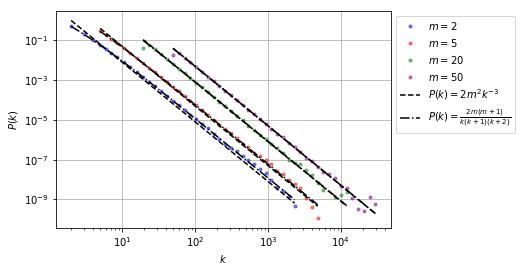

In [26]:
marker = "."
a = 0.5
s = 1.2

x,y = logbin((np.asarray(d2).flatten()),scale = s)
#plt.figure(figsize = (10,5))
plt.loglog(x,y,marker,color = "blue",label = "$m = 2$",
            alpha = a)
#get some space to plot
space = np.arange(x[0],x[-1],0.1)
plt.loglog(space,cubic(space,2),"--", color = "black")
plt.loglog(space,factorial(space,2),"-.", color = "black")

x,y = logbin(np.asarray(d5).flatten(),scale = s)
space = np.arange(x[0],x[-1],0.1)
plt.loglog(x,y,marker,color = "red",label = "$m = 5$",
            alpha = a)
plt.loglog(space,cubic(space,5),"--", color = "black")
plt.loglog(space,factorial(space,5),"-.", color = "black")

x,y = logbin(np.asarray(d20).flatten(),scale = s)
space = np.arange(x[0],x[-1],0.1)
plt.loglog(x,y,marker,color = "green",label = "$m = 20$",
            alpha = a)
plt.loglog(space,cubic(space,m=20),"--", color = "black")
plt.loglog(space,factorial(space,m=20),"-.", color = "black")


x,y = logbin(np.asarray(d50).flatten(),scale = s)
space = np.arange(x[0],x[-1],0.1)
plt.loglog(x,y,marker,color = "purple",label = "$m = 50$",
            alpha = a)
plt.loglog(space,cubic(space,m=50),"--", color = "black", label = "$P(k) = 2m^{2}k^{-3}$")
plt.loglog(space,factorial(space,m=50),"-.", color = "black", label = "$P(k) = \\frac{2m(m+1)}{k(k+1)(k+2)}$")



plt.grid()
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend(bbox_to_anchor = (1,1))
#plt.savefig("Figures\\fixed_N_5_changing_m.pdf",bbox_inches='tight')

We see that both theoretical PDFs fit the data quite well and have approvimately the same gradient, especialling in the large $k$ region. As exepcted, we see the discrite PDF to give a better match to the data even at low $k$ where the other one fails. We can now produce a fractional difference plot in hopes of a more instructive picture:

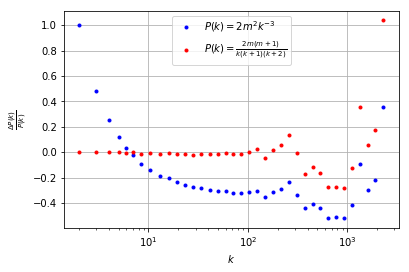

In [121]:
x,y = logbin(np.asarray(d2).flatten(),scale = 1.2)

plt.semilogx(x,(cubic(x,m=2)-y)/y,".", color = "blue", label = "$P(k) = 2m^{2}k^{-3}$")
plt.semilogx(x,(factorial(x,m=2)-y)/y,".", color = "red", label = "$P(k) = \\frac{2m(m+1)}{k(k+1)(k+2)}$")
plt.grid()
plt.xlabel("$k$")
plt.ylabel("$\\frac{\\Delta{P(k)}}{P(k)}$")
plt.legend()

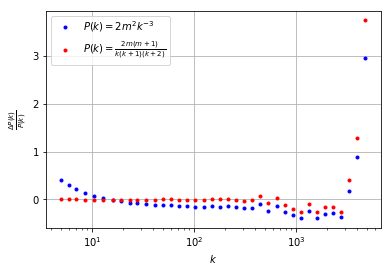

In [120]:
x,y = logbin(np.asarray(d5).flatten(),scale = 1.2)

plt.semilogx(x,(cubic(x,m=5)-y)/y,".", color = "blue", label = "$P(k) = 2m^{2}k^{-3}$")
plt.semilogx(x,(factorial(x,m=5)-y)/y,".", color = "red", label = "$P(k) = \\frac{2m(m+1)}{k(k+1)(k+2)}$")
plt.grid()
plt.xlabel("$k$")
plt.ylabel("$\\frac{\\Delta{P(k)}}{P(k)}$")
plt.legend()

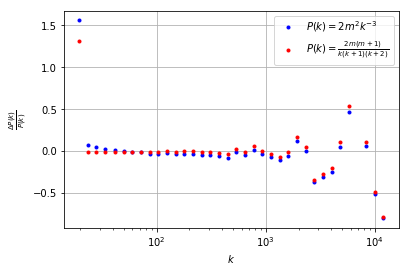

In [119]:
x,y = logbin(np.asarray(d20).flatten(),scale = 1.2)

plt.semilogx(x,(cubic(x,m=20)-y)/y,".", color = "blue", label = "$P(k) = 2m^{2}k^{-3}$")
plt.semilogx(x,(factorial(x,m=20)-y)/y,".", color = "red", label = "$P(k) = \\frac{2m(m+1)}{k(k+1)(k+2)}$")
plt.grid()
plt.xlabel("$k$")
plt.ylabel("$\\frac{\\Delta{P(k)}}{P(k)}$")
plt.legend()

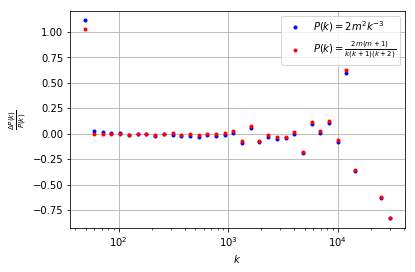

In [118]:
x,y = logbin(np.asarray(d50).flatten(),scale = 1.2)

plt.semilogx(x,(cubic(x,m=50)-y)/y,".", color = "blue", label = "$P(k) = 2m^{2}k^{-3}$")
plt.semilogx(x,(factorial(x,m=50)-y)/y,".", color = "red", label = "$P(k) = \\frac{2m(m+1)}{k(k+1)(k+2)}$")
plt.grid()
plt.xlabel("$k$")
plt.ylabel("$\\frac{\\Delta{P(k)}}{P(k)}$")
plt.legend()

Put all fractional difference plots together:

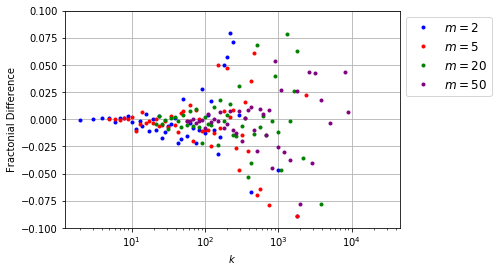

In [141]:
s = 1.1

x,y = logbin(np.asarray(d2).flatten(),scale = s)


plt.semilogx(x,(factorial(x,m=2)-y)/y,".", color = "blue", label = "$m = 2$")

x,y = logbin(np.asarray(d5).flatten(),scale = s)

plt.semilogx(x,(factorial(x,m=5)-y)/y,".", color = "red", label = "$m = 5$")

x,y = logbin(np.asarray(d20).flatten(),scale = s)

plt.semilogx(x,(factorial(x,m=20)-y)/y,".", color = "green", label = "$m = 20$")

x,y = logbin(np.asarray(d50).flatten(),scale = s)

plt.semilogx(x,(factorial(x,m=50)-y)/y,".", color = "purple", label = "$m = 50$")

#plt.ylim(-0.1,0.1)
plt.legend(bbox_to_anchor = (1,1),fontsize = "large")
plt.grid()
plt.xlabel("$k$")
plt.ylabel("Fractonial Difference")
plt.savefig("fdifference_evert_zoom.pdf", bbox_inches = "tight")

Additional checks (not includes in report):

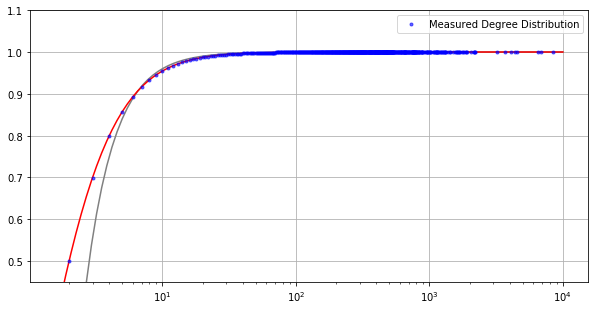

In [21]:
x,y = logbin(d,scale = 1)
plt.figure(figsize = (10,5))


def cubic_cdf(k,m=2):
    return (1 - (m**2/k**2))

def discrete_cdf(k,m=2):
    return (k**2 + 3*k - m**2 - m + 2) / ((k+1)*(k+2))
    
    

space = np.logspace(0.2,4,100)    
plt.semilogx(space,cubic_cdf(space),color = "gray")
plt.semilogx(space,discrete_cdf(space), color = "red")
plt.semilogx(x,np.cumsum(y),'.',color = "blue",label = "Measured Degree Distribution",alpha= 0.6)
plt.ylim([0.45,1.1])
plt.grid()
plt.legend()

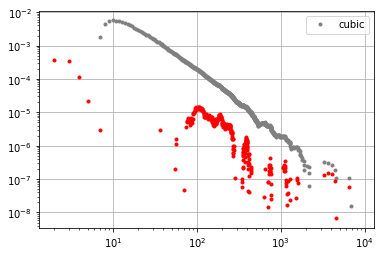

In [22]:
space = np.logspace(0.2,4,100)    
data_cdf = np.cumsum(y)
plt.loglog(x,(cubic_cdf(x)-data_cdf)/data_cdf,'.',color = "gray",label = "cubic")
plt.loglog(x,(discrete_cdf(x)-data_cdf)/data_cdf,'.', color = "red")
#plt.semilogx(x,np.cumsum(y),'.',color = "blue",label = "Measured Degree Distribution",alpha= 0.6)
#plt.ylim([0.45,1.1])
plt.grid()
plt.legend()

### Statistics

Below we will use statisticall methods to help establish whether data fits theory.

In [147]:
#will
from scipy.stats import chisquare
from scipy.stats import ks_2samp
x,y = logbin(np.asarray(d50).flatten(),scale = 1.1)


cubic_data = cubic(x)
chi,p = chisquare(y,cubic_data,ddof = len(x)-3)
print(p)
D,p = ks_2samp(y,cubic_data)
print(p)


cubic_data = factorial(x)
chi,p = chisquare(y,cubic_data,ddof = len(x)-3)
print(p)
D,p = ks_2samp(y,cubic_data)
print(p)



6.464710628403037e-18
0.00015750798605072063
1.109035533027885e-12
0.0003405299671514096


Above we have implemented the pearson chi squared test to examine whether our suggested theoretical distributions are really a godd fit for the data. The p-values seem to make sence giving a value closer to 1 for the discrete distribution which we know is better than the continuous but still I am not sure what it means to have a p-value biger than 0.5. Nonetheless, below we are fitting the data to a unifrom distribution and we see the extremely low p-value we would have expected. Lastly, I'm not sure if I am interpretting the degrees of freedom the right way.

In [46]:
#test for some other distribution
#eg flat
cubic_data = cubic(x)**0
chi,p = chisquare(y,cubic_data,ddof = 68)
print(p)

1.370977009183487e-16


https://stats.stackexchange.com/questions/27958/testing-randomly-generated-data-against-its-intended-distribution#27966

This above link contains a discussion about whether it is a better to use hypothesis testing to evaluate our theorritcal predictions or corelation from pp and qq plots. Below I am going to try the qq method.

Will probbly need this as well:
http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit

0.9980830799028669  +-  0.002000139812146725
-0.016970704061372466  +-  0.019087789548799666


1.048508018108285  +-  0.007227861146037785
0.2075454521180946  +-  0.06897713060715782


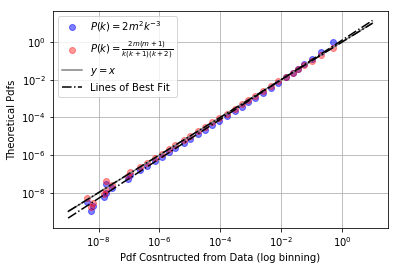

In [29]:
x,y = logbin(d,scale = 1.2)
q2 = cubic(x)
q3 = factorial(x)
q1 = y

space = np.logspace(-9, 1, num=500)

plt.loglog(q1,q2,"o",color = "blue",alpha = 0.5,label = "$P(k) = {2m^2}k^{-3}$")
plt.loglog(q1,q3,"o",color = "red",alpha= 0.4,label = "$P(k) = \\frac{2m(m+1)}{k(k+1)(k+2)}$")
plt.loglog(space,space,"-",color = "gray",label = "$y = x$")
plt.grid()

#we can fit straight lines
def line(x,A,B):
    return (A*x) + B

coef, cov = curve_fit(line,np.log(q1[:-8]),np.log(q3[:-8]))
print(coef[0], " +- ",np.sqrt(cov[0,0]))
print(coef[1], " +- ",np.sqrt(cov[1,1]))
print()
print()

coef1, cov1 = curve_fit(line,np.log(q1[:-8]),np.log(q2[:-8]))
print(coef1[0], " +- ",np.sqrt(cov1[0,0]))
print(coef1[1], " +- ",np.sqrt(cov1[1,1]))


plt.loglog(space,np.exp(line(np.log(space),*coef)),'-.',color = "black",label = "Lines of Best Fit")
plt.loglog(space,np.exp(line(np.log(space),*coef1)),'-.',color = "black")
plt.xlabel("Pdf Cosntructed from Data (log binning)")
plt.ylabel("Theoretical Pdfs")
plt.legend()
plt.savefig("Figures\qq_plot_m_2.pdf")

This is a nice figure. For a start, both PDFs follow the data well but especially the discrete one follows the $y = x$ exactly. This is seen both visually and from the error coefficients of the fit. Another, more instructive (perhaps) plot, would be percentage the difference bewteen theory PDF and data against data PDF. Before we do that however we also can chech the $R^2$ score of the two lines:

In [31]:
from sklearn.metrics import r2_score
print (r2_score(q1[:-8],q2[:-8]))
print (r2_score(q1[:-8],q3[:-8]))

0.05066039231553077
0.9999987898033769


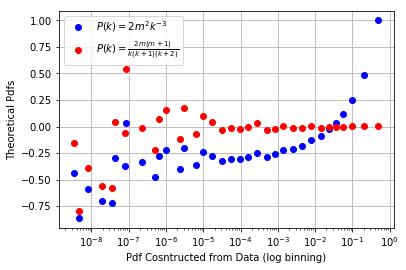

In [109]:
x,y = logbin(d,scale = 1.2)
q2 = cubic(x)
q3 = factorial(x)
q1 = y

space = np.logspace(-9, 1, num=500)

plt.semilogx(q1,(q2-q1)/q1,"o",color = "blue",label = "$P(k) = {2m^2}k^{-3}$")
plt.semilogx(q1,(q3-q1)/q1,"o",color = "red",label = "$P(k) = \\frac{2m(m+1)}{k(k+1)(k+2)}$")
#plt.loglog(space,space,"-",color = "gray",label = "$y = x$")
plt.grid()


plt.xlabel("PDF Cosntructed from Data (log binning)")
plt.ylabel("Theoretical PDFs")
plt.legend()
plt.savefig("Figures\Delta_qq_plot_m_2.pdf")

## Investigation of Finite Size phenomena

In this section we will investigate what happens when we keep $m$ fixed and vary the total number of nodes $N$

In [26]:
#get some statistics:
d10E7 = []
for i in range(5):
    %time g, da, t = grow_a_net((9999997),2)
    d10E7.append(da)

Wall time: 3min 1s
Wall time: 52.9 s
Wall time: 58.6 s
Wall time: 58.7 s
Wall time: 59.3 s


In [27]:
#save the data
np.savetxt("Data_files\\N_10E7_m_2.txt",d10E7)

Below this point I will access the collected data and used them to investigate $k_1$ and perform a data collapse.

In [61]:
data =[]
for i in range(2,8):
    data.append(np.loadtxt("Data_files\\N_10E"+str(i)+"_m_5.txt"))

In [62]:
data[0]

array([[26., 46., 24., ...,  5.,  5.,  5.],
       [26., 11., 39., ...,  5.,  5.,  5.],
       [46., 23., 49., ...,  5.,  5.,  5.],
       ...,
       [15.,  8., 45., ...,  5.,  5.,  5.],
       [29.,  7., 66., ...,  5.,  5.,  5.],
       [15., 37., 23., ...,  5.,  5.,  5.]])

In [63]:
#need the largest degree
#data is a list of lists of arrays
#to get the largest degrees for each list we need
k_maxs = [[max(k) for k in datum] for datum in data]

In [142]:
print([len(k) for k in k_maxs])

[100, 100, 100, 100, 10, 2]


In [98]:
dd = (k_maxs[-1][0] - k_maxs[-1][1])/2

In [96]:
#use this list of k_maxs to get the mean k_max and its standard deviation
mean_k_1 = [np.mean(ks) for ks in k_maxs]
mean_k_1
std_k_1 = [np.std(ks) for ks in k_maxs]
std_k_1[-1] = dd

In [101]:
print(np.log(ns),np.log(mean_k_1))

[ 4.60517019  6.90775528  9.21034037 11.51292546 13.81551056 16.11809565] [4.03459456 5.21493576 6.37186822 7.51112544 8.80546509 9.55062675]


[0.49002074 1.83735423]
[[0.01454921        nan]
 [       nan 0.16124521]]


C:\Users\George\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


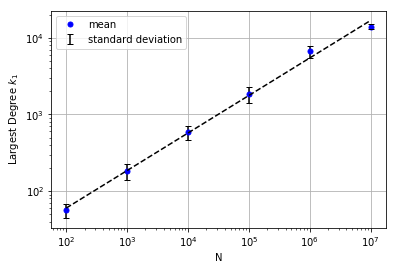

In [116]:
ns = [100,1000,10000,100000,1000000,10000000]
plt.loglog(ns,mean_k_1,"o",markersize = 5,color = "blue",label = "mean")
plt.errorbar(ns,mean_k_1,yerr = std_k_1,marker = 'o',fmt = "none",
             color = "black",capsize = 3.0,label = "standard deviation")
plt.grid()
def line(x,A,B):
    return A*x + B

coef, cov = curve_fit(line,np.log(ns),np.log(mean_k_1))

plt.loglog(ns, np.exp(line(np.log(ns),*coef)),"--", color = "black")

plt.xlabel("N")
plt.ylabel("Largest Degree $k_1$")
plt.legend()

print(coef)
print(np.sqrt(cov))

plt.savefig("BA_largest_k_investigationp.pdf")

In [149]:
#let's do the data collapse

flat_data = [[int(d) for d in datum.flatten()] for datum in data]


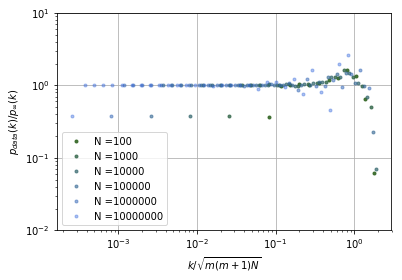

In [152]:
s = 1.3
marker = '.'
c=0
for i,da in enumerate(flat_data):
    c += (1/(len(flat_data)+1))
    x,y = logbin((da),scale = s)
    plt.loglog(x/np.sqrt(30*ns[i]),y/factorial(x,m=5),marker, color = (0.2,0.4,c),
               label = "N ="+str(ns[i]),alpha = 1-0.7*c)
plt.ylim(0.01,10)    
plt.grid()
plt.legend()
plt.xlabel("${k} /{\\sqrt{m(m+1)N}}$")
plt.ylabel("$p_{data}(k) / p_{\\infty}(k)$")
plt.savefig("Figures\\Final_Data_Collapse_1.pdf")